In [ ]:
!pip install traffic openap openap-top

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fastmeteo.source import ArcoEra5
from openap import FuelFlow, aero, contrail, top
from traffic.core import Flight, Traffic
from cartopy import crs as ccrs
from cartopy.feature import BORDERS
import matplotlib.dates as mdates


In [20]:
TYPECODE = "A320"

# maximum diversion vertically
ALT_BOUND = 2000

LAT0, LAT1 = 26, 66
LON0, LON1 = -15, 40

In [ ]:
def calc_fuel(flight):
    if isinstance(flight, pd.DataFrame):
        flight = Flight(flight)

    fuelflow = FuelFlow(TYPECODE)
    mass0 = flight.mass0_max

    if "tas" in flight.data.columns and flight.tas_max > 0:
        tas = flight.data.tas
    else:
        vg = flight.data.groundspeed * aero.kts
        psi = np.radians(flight.data.track)
        vgx = vg * np.sin(psi)
        vgy = vg * np.cos(psi)
        vax = vgx - flight.data.u_component_of_wind
        vay = vgy - flight.data.v_component_of_wind
        tas = np.sqrt(vax**2 + vay**2) / aero.kts

        tas = np.where(tas == tas, tas, flight.data.groundspeed)
        flight = flight.assign(tas=tas)

    mass = mass0 * np.ones_like(tas)
    dt = flight.data.timestamp.diff().bfill().dt.total_seconds()

    # fast way to calculate fuel flow without iterate over rows
    for i in range(6):
        ff = fuelflow.enroute(
            mass=mass,
            tas=tas,
            alt=flight.data.altitude,
            vs=flight.data.vertical_rate,
        )
        fuel = ff * dt
        mass[1:] = mass0 - fuel.cumsum()[:-1]

    flight = flight.assign(
        fuel_flow=ff,
        fuel=fuel,
        total_fuel=fuel.sum(),
        mass=mass,
    )

    return flight

In [4]:
def compute_contrail_time(flight: Flight):
    if flight.query("persistent") is None:
        return 0

    fi = flight.query("persistent").split("10min")

    if fi.sum() == 0:
        return 0

    contrail_time = np.sum([f.duration for f in fi]).total_seconds() // 60
    return contrail_time


In [5]:
def agg_contrail_conditions(flight):
    flight = flight.assign(
        rhi=lambda d: contrail.relative_humidity(
            d.specific_humidity,
            aero.pressure(d.altitude * aero.ft),
            d.temperature,
            to="ice",
        ),
        crit_temp=lambda d: contrail.critical_temperature_water(
            aero.pressure(d.altitude * aero.ft)
        ),
        sac=lambda d: d.temperature < d.crit_temp,
        issr=lambda d: d.rhi > 1,
        persistent=lambda d: d.sac & d.issr,
    )
    return flight


In [8]:
# file: eu_flights_2022feb20_filter_resample_meteo.parquet.gz
df_base = pd.read_parquet("https://figshare.com/ndownloader/files/55632065")
t_base = Traffic(df_base)

# file: all_optimized.parquet
df_optimized = pd.read_parquet("https://figshare.com/ndownloader/files/55634282")
t_optimized = Traffic(df_optimized)

# file: grid_era5_smoothed.parquet.gz
df_cost_era5 = pd.read_parquet("https://figshare.com/ndownloader/files/55632059")

# file: grid_arpege_smoothed.parquet.gz
df_cost_arpege = pd.read_parquet("https://figshare.com/ndownloader/files/55632062")


In [9]:
wind_era5 = df_cost_era5[
    ["ts", "timestamp", "latitude", "longitude", "altitude", "height", "u", "v"]
].eval("h=height")

wind_arpege = df_cost_arpege[
    ["ts", "timestamp", "latitude", "longitude", "altitude", "height", "u", "v"]
].eval("h=height")


In [10]:
wind_era5.head(5)

,ts,timestamp,latitude,longitude,altitude,height,u,v,h
0,0.0,2022-02-20 00:00:00+00:00,26.0,-15.0,20000.0,6096.0,17.899839,-2.120699,6096.0
1,0.0,2022-02-20 00:00:00+00:00,26.0,-14.5,20000.0,6096.0,18.218530,-1.000751,6096.0
2,0.0,2022-02-20 00:00:00+00:00,26.0,-14.0,20000.0,6096.0,18.484830,0.167929,6096.0
3,0.0,2022-02-20 00:00:00+00:00,26.0,-13.5,20000.0,6096.0,18.762054,1.168413,6096.0
4,0.0,2022-02-20 00:00:00+00:00,26.0,-13.0,20000.0,6096.0,19.208949,1.990154,6096.0


In [86]:
base_flight_id = "461fa0_08596_0"


flight = t_base[base_flight_id].assign(
    ts=lambda d: (d.timestamp - d.timestamp.iloc[0]).dt.total_seconds()
)

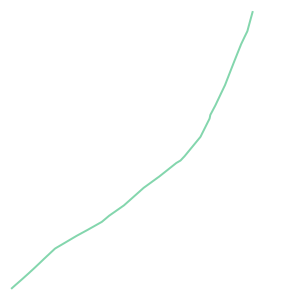

In [12]:
flight

In [18]:
flight.map_leaflet(zoom=3, highlight={"#bd0026": lambda x: x.query("persistent")})

Map(center=[np.float64(43.1731507109641), np.float64(4.3880423893159906)], controls=(ZoomControl(options=['pos…

In [67]:
def plot_costs_grid_with_flights(
    flights,
    colors,
    labels,
    df_cost,
    grid_color="Purples",
    ncols=3,
    nrows=2,
    legend_loc="lower right",
):
    proj = ccrs.PlateCarree()

    fig, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(5 * ncols, 3.5 * nrows),
        subplot_kw=dict(
            projection=ccrs.TransverseMercator(
                central_longitude=(LON0 + LON1) / 2,
                central_latitude=(LAT0 + LAT1) / 2,
            )
        ),
    )

    plot_time_step = flights[0].duration.total_seconds() / (ncols * nrows)

    for i, ax in enumerate(axes.flatten()):
        ax.set_extent([-20, 40, 25, 65])
        ax.add_feature(BORDERS, lw=0.5, edgecolor="gray")
        ax.coastlines(resolution="110m", lw=0.5, color="gray")

        current_flight_point = (
            flights[0]
            .data.query(
                f"{(i + 1) * plot_time_step}<=ts<={(i + 1) * plot_time_step + 600}"
            )
            .iloc[0]
        )

        grid_time_idx = np.argmin(
            abs(df_cost.timestamp.unique() - current_flight_point.timestamp)
        )
        sel_time = pd.to_datetime(df_cost.timestamp.unique()[grid_time_idx])

        grid_altitude_idx = np.argmin(
            abs(df_cost.height.unique() - current_flight_point.altitude * aero.ft)
        )
        sel_altitude = df_cost.height.unique()[grid_altitude_idx]

        df_cost_pivot = df_cost.query(
            f"height=={sel_altitude} and timestamp==@sel_time"
        ).pivot(index="latitude", columns="longitude", values="cost")

        lat, lon, val = (
            df_cost_pivot.index.values,
            df_cost_pivot.columns.values,
            df_cost_pivot.values,
        )

        ax.contourf(
            lon,
            lat,
            val,
            transform=proj,
            alpha=0.7,
            cmap=grid_color,
            vmin=0,
            vmax=df_cost.cost.quantile(0.99),
            antialiased=True,
            # edgecolors="face",
        )

        ax.text(
            0.03,
            0.97,
            f"Time: {current_flight_point.timestamp.strftime('%Y-%m-%d %H:%M')}\n"
            f"Grid Altitude: {int(round(current_flight_point.altitude, -2))} ft",
            transform=ax.transAxes,
            fontsize=14,
            va="top",
        )

        for r, p in flights[0].data.iloc[[0, -1]].iterrows():
            ax.scatter(p.longitude, p.latitude, c="k", transform=proj)

    for k, flight in enumerate(flights):
        for i, ax in enumerate(axes.flatten()):
            current_flight_path = flight.data.query(
                f"ts<={(i + 1) * plot_time_step + 600}"
            )
            remaining_flight_path = flight.data.query(
                f"ts>{(i + 1) * plot_time_step + 600}"
            )
            current_flight_point = current_flight_path.iloc[-1]

            grid_time_idx = np.argmin(
                abs(df_cost.timestamp.unique() - current_flight_point.timestamp)
            )
            sel_time = pd.to_datetime(df_cost.timestamp.unique()[grid_time_idx])

            grid_altitude_idx = np.argmin(
                abs(df_cost.height.unique() - current_flight_point.altitude * aero.ft)
            )
            sel_altitude = df_cost.height.unique()[grid_altitude_idx]

            df_cost_pivot = df_cost.query(
                f"height=={sel_altitude} and timestamp==@sel_time"
            ).pivot(index="latitude", columns="longitude", values="cost")

            ax.plot(
                current_flight_path.longitude,
                current_flight_path.latitude,
                color=colors[k],
                lw=2,
                transform=proj,
                label=labels[k],
            )

            ax.plot(
                remaining_flight_path.longitude,
                remaining_flight_path.latitude,
                color=colors[k],
                lw=1,
                ls="--",
                transform=proj,
            )

            ax.legend(loc=legend_loc, fontsize=11)

    plt.tight_layout()
    return plt


<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

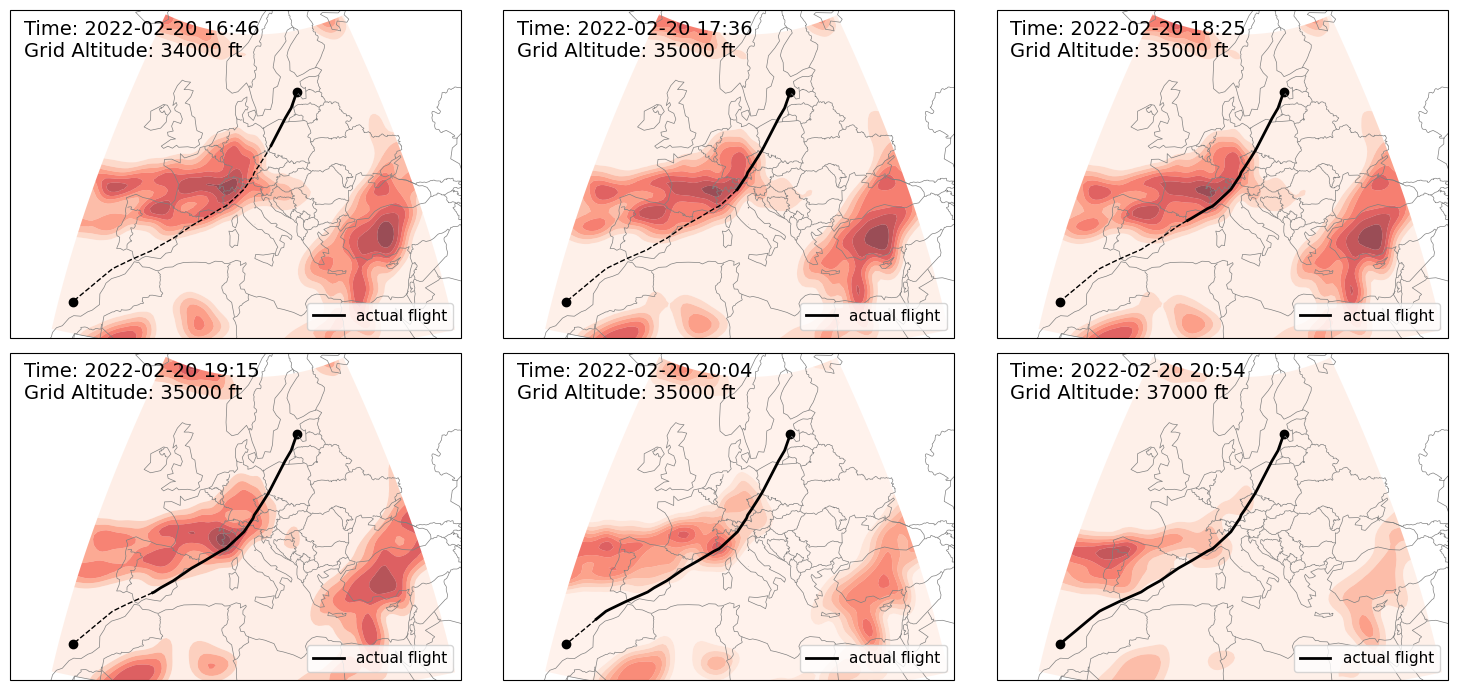

In [68]:
plot_costs_grid_with_flights(
    flights=[flight],
    colors=["k"],
    labels=["actual flight"],
    df_cost=df_cost_era5,
    grid_color="Reds",
)

## Generate the optimal flights

In [ ]:
def estimate_mass(flight):
    dist_km = flight.distance() * aero.nm / 1000
    crusie_alt = flight.altitude_median
    mass0 = 1.8533 * dist_km - 1.99133 * crusie_alt + 133497
    mass0 = mass0 - 2000  # remove the climbing fuel
    mass0 = min(mass0, 76000)
    return mass0


def df_to_flight(df, flight, mass0, appendix):
    return calc_fuel(
        Flight(
            df.assign(
                timestamp=lambda x: flight.start + pd.to_timedelta(x.ts, unit="s"),
                icao24=flight.icao24,
                callsign=flight.callsign,
                typecode=flight.typecode,
                registration=flight.registration,
                operator=flight.operator_max,
                flight_id=flight.flight_id + appendix,
                mass0=mass0,
            )
        )
    )

In [70]:
mass0 = estimate_mass(flight)
m0 = mass0 / 78000

flight = calc_fuel(flight.assign(mass0=mass0))

In [29]:
flight.data

,timestamp,icao24,latitude,longitude,groundspeed,track,vertical_rate,callsign,altitude,geoaltitude,...,sac,issr,persistent,ts,mass0,tas,fuel_flow,fuel,total_fuel,mass
897535,2022-02-20 15:56:30+00:00,461fa0,57.980021,22.241730,449.0,207.193394,64.0,FIN9CM,34000.0,32250.0,...,True,False,False,0.0,69505.066748,447.491381,0.748692,22.460746,12051.304137,69505.066748
897536,2022-02-20 15:57:00+00:00,461fa0,57.913777,22.177414,450.5,207.446434,96.0,FIN9CM,34000.0,32250.0,...,True,False,False,30.0,69505.066748,449.262138,0.760588,22.817653,12051.304137,69482.606002
897537,2022-02-20 15:57:30+00:00,461fa0,57.847533,22.113098,452.0,207.699473,128.0,FIN9CM,34000.0,32250.0,...,True,False,False,60.0,69505.066748,451.035155,0.772430,23.172888,12051.304137,69459.788349
897538,2022-02-20 15:58:00+00:00,461fa0,57.827097,22.093048,454.0,207.693886,64.0,FIN9CM,34000.0,32250.0,...,True,False,False,90.0,69505.066748,453.015719,0.753108,22.593253,12051.304137,69436.615461
897539,2022-02-20 15:58:30+00:00,461fa0,57.771561,22.038929,456.0,207.407575,64.0,FIN9CM,34000.0,32250.0,...,True,False,False,120.0,69505.066748,454.652031,0.754485,22.634542,12051.304137,69414.022209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898126,2022-02-20 20:52:00+00:00,461fa0,29.613834,-13.133994,433.0,216.552473,64.0,FIN9CM,37025.0,35350.0,...,True,False,False,17730.0,69505.066748,455.417296,0.623318,18.699537,12051.304137,57547.214499
898127,2022-02-20 20:52:30+00:00,461fa0,29.613834,-13.133994,433.0,216.552473,64.0,FIN9CM,37025.0,35350.0,...,True,False,False,17760.0,69505.066748,455.420445,0.623165,18.694955,12051.304137,57528.514962
898128,2022-02-20 20:53:00+00:00,461fa0,29.613834,-13.133994,433.0,216.552473,64.0,FIN9CM,37025.0,35350.0,...,True,False,False,17790.0,69505.066748,455.423594,0.623013,18.690375,12051.304137,57509.820007
898129,2022-02-20 20:53:30+00:00,461fa0,29.613834,-13.133994,433.0,216.552473,64.0,FIN9CM,37025.0,35350.0,...,True,False,False,17820.0,69505.066748,455.426743,0.622860,18.685798,12051.304137,57491.129632


In [71]:
# altitude bound
flight_alt_min_bound = flight.data.altitude.quantile(0.10) - ALT_BOUND
flight_alt_max_bound = flight.data.altitude.quantile(0.90) + ALT_BOUND

# algin the cost grid and wind time: ts=0 should be the start of flight
start_day = flight.start.floor("1d")
start_seconds = (flight.start - start_day).total_seconds()

grid_start_time = flight.start - pd.Timedelta("1h")
grid_stop_time = flight.stop + pd.Timedelta("1h")

wind_era5_flight = wind_era5.query(
    f"'{grid_start_time}'<=timestamp<='{grid_stop_time}'"
).assign(ts=lambda x: (x.ts - start_seconds))

wind_arpege_flight = wind_arpege.query(
    f"'{grid_start_time}'<=timestamp<='{grid_stop_time}'"
).assign(ts=lambda x: (x.ts - start_seconds))


interpolant_era5 = top.tools.interpolant_from_dataframe(
    df_cost_era5.query(f"'{grid_start_time}'<=timestamp<='{grid_stop_time}'").assign(
        ts=lambda x: (x.ts - start_seconds)
    )
)

interpolant_arpege = top.tools.interpolant_from_dataframe(
    df_cost_arpege.query(f"'{grid_start_time}'<=timestamp<='{grid_stop_time}'").assign(
        ts=lambda x: (x.ts - start_seconds)
    )
)


### Define the optimizer

In [72]:
optimizer = top.Cruise(
    actype=TYPECODE,
    origin=flight.data[["latitude", "longitude"]].iloc[0].tolist(),
    destination=flight.data[["latitude", "longitude"]].iloc[-1].tolist(),
    m0=m0,
)

### Generate fuel optimal flight

In [ ]:
optimizer.setup(debug=False, max_iteration=3000, max_nodes=60)
optimizer.enable_wind(wind_era5_flight)

df_flight_opt_fuel = optimizer.trajectory(
    objective="fuel",
    h_min=flight_alt_min_bound * aero.ft,
    h_max=flight_alt_max_bound * aero.ft,
)

flight_opt_fuel = df_to_flight(df_flight_opt_fuel, flight, mass0, "_fuel")

<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

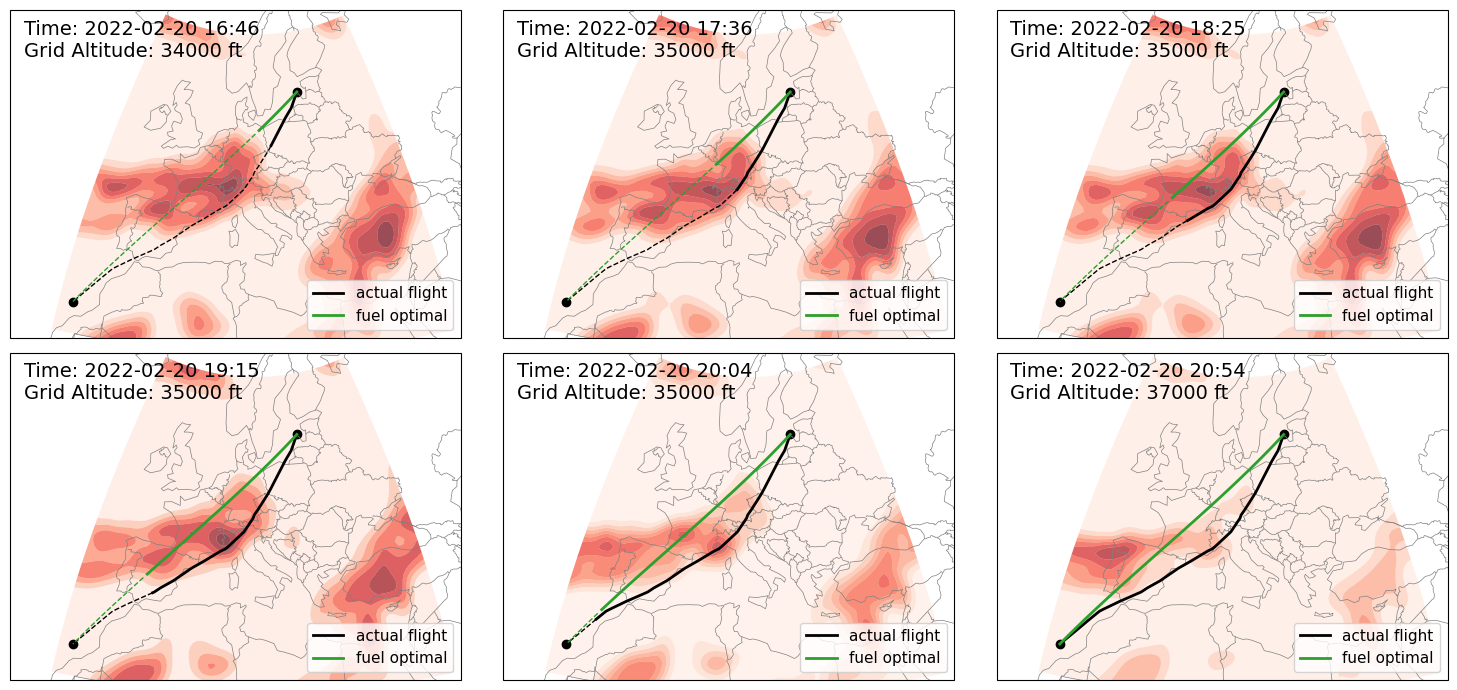

In [74]:
plot_costs_grid_with_flights(
    flights=[flight, flight_opt_fuel],
    colors=["k", "tab:green"],
    labels=["actual flight", "fuel optimal"],
    df_cost=df_cost_era5,
    grid_color="Reds",
)

### Generate contrail optimal flights

- lower coefficient means trajectory is less contrail optimal, but more fuel optimal
- higher coefficient means trajectory is more contrail optimal, but less fuel optimal


In [78]:
def optimize_one(optimizer, grid_name, coef, df_flight_guess=None):
    def objective(x, u, dt, coef, **kwargs):
        grid_cost = optimizer.obj_grid_cost(
            x, u, dt, time_dependent=True, n_dim=4, **kwargs
        )
        fuel_cost = optimizer.obj_fuel(x, u, dt, **kwargs)
        return grid_cost * coef + fuel_cost * (1 - coef)

    if grid_name == "era5":
        wind_grid = wind_era5_flight
        interpolant = interpolant_era5
    elif grid_name == "arpege":
        wind_grid = wind_arpege_flight
        interpolant = interpolant_arpege

    optimizer.enable_wind(wind_grid)
    df_optimized = optimizer.trajectory(
        objective=objective,
        interpolant=interpolant,
        initial_guess=df_flight_guess,
        h_min=flight_alt_min_bound * aero.ft,
        h_max=flight_alt_max_bound * aero.ft,
        coef=coef,
    )

    flight_optimized = df_to_flight(df_optimized, f"_{grid_name}_0{int(coef * 10)}")
    return flight_optimized


In [79]:
flight_opt_era5_03 = optimize_one(optimizer, "era5", 0.3, df_flight_opt_fuel)
flight_opt_era5_06 = optimize_one(optimizer, "era5", 0.6, df_flight_opt_fuel)
flight_opt_arpege_03 = optimize_one(optimizer, "arpege", 0.3, df_flight_opt_fuel)
flight_opt_arpege_06 = optimize_one(optimizer, "arpege", 0.6, df_flight_opt_fuel)

<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

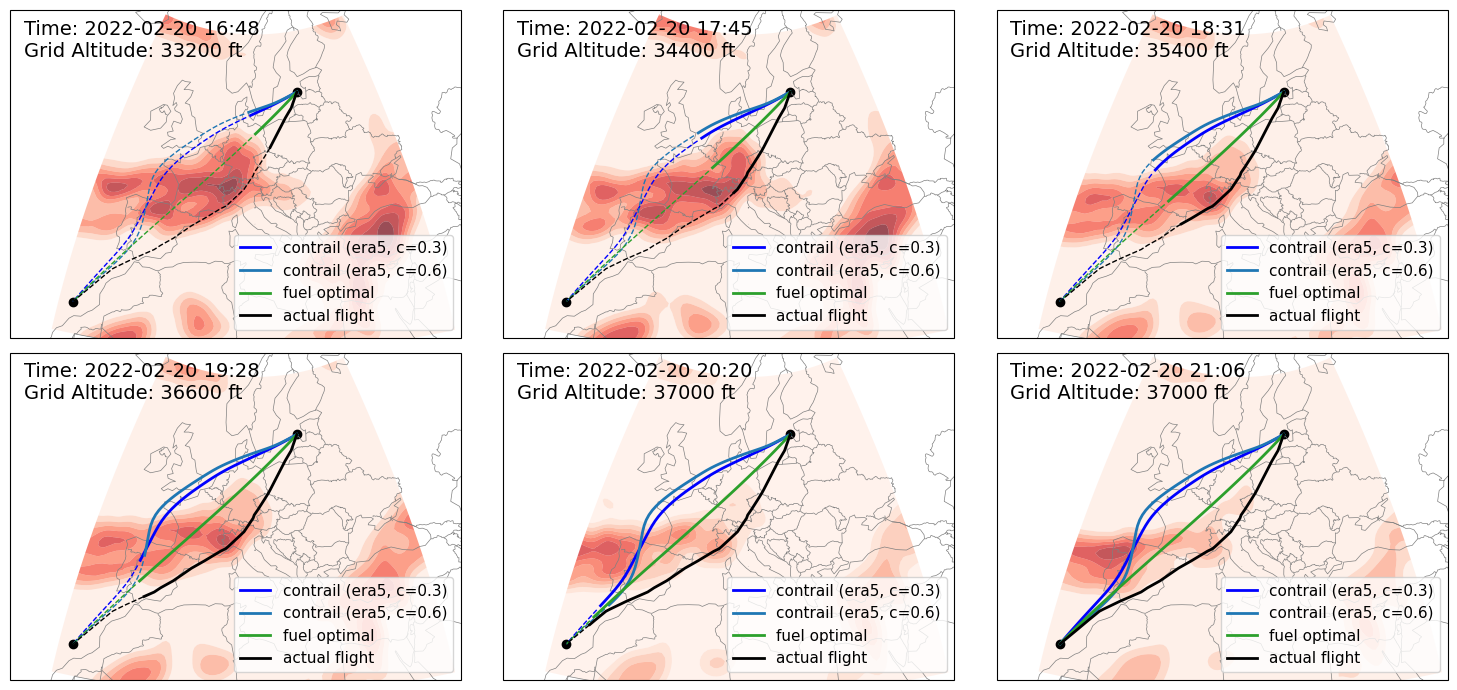

In [80]:
colors = ["blue", "tab:blue", "tab:green", "k"]

labels = [
    "contrail (era5, c=0.3)",
    "contrail (era5, c=0.6)",
    "fuel optimal",
    "actual flight",
]

plot_costs_grid_with_flights(
    flights=[
        flight_opt_era5_03,
        flight_opt_era5_06,
        flight_opt_fuel,
        flight,
    ],
    colors=colors,
    labels=labels,
    df_cost=df_cost_era5,
    grid_color="Reds",
)


<module 'matplotlib.pyplot' from '/home/junzi/env/flight/lib/python3.12/site-packages/matplotlib/pyplot.py'>

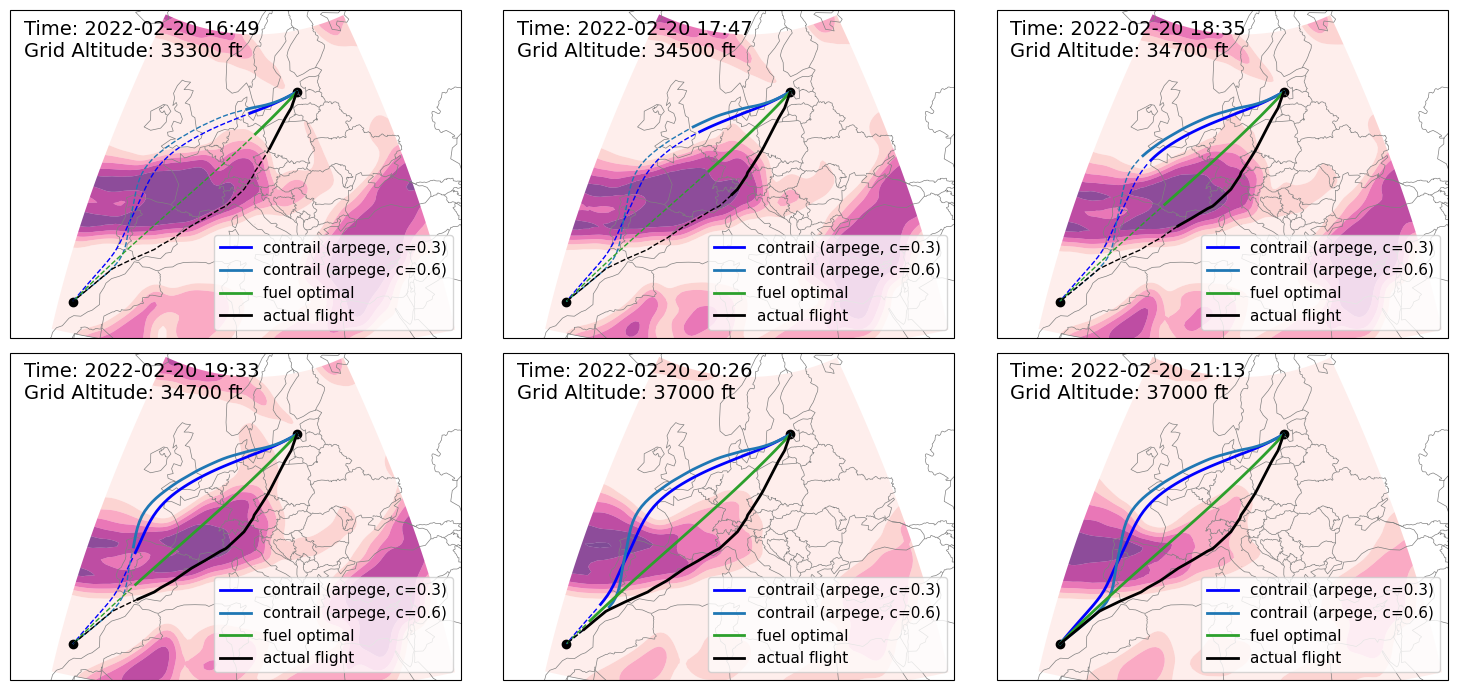

In [81]:
labels = [
    "contrail (arpege, c=0.3)",
    "contrail (arpege, c=0.6)",
    "fuel optimal",
    "actual flight",
]

plot_costs_grid_with_flights(
    flights=[
        flight_opt_arpege_03,
        flight_opt_arpege_06,
        flight_opt_fuel,
        flight,
    ],
    colors=colors,
    labels=labels,
    df_cost=df_cost_arpege,
    grid_color="RdPu",
)


In [83]:
arco_grid = ArcoEra5(local_store="/tmp/era5-zarr/", model_levels=137)

t_opt = Traffic.from_flights(
    [
        flight,
        flight_opt_fuel,
        flight_opt_era5_03,
        flight_opt_era5_06,
        flight_opt_arpege_03,
        flight_opt_arpege_06,
    ]
)

t_opt = Traffic(agg_contrail_conditions(arco_grid.interpolate(t_opt.data)))


init local zarr from remote, hour: 2022-02-20 15:00:00
syncing from remote, hour: 2022-02-20 16:00:00
syncing from remote, hour: 2022-02-20 17:00:00
syncing from remote, hour: 2022-02-20 18:00:00
syncing from remote, hour: 2022-02-20 19:00:00
syncing from remote, hour: 2022-02-20 20:00:00
syncing from remote, hour: 2022-02-20 21:00:00
syncing from remote, hour: 2022-02-20 22:00:00


In [84]:
t_opt

,count
flight_id,
461fa0_08596_0,596
461fa0_08596_0_arpege_03,61
461fa0_08596_0_arpege_06,61
461fa0_08596_0_era5_03,61
461fa0_08596_0_era5_06,61
461fa0_08596_0_fuel,61


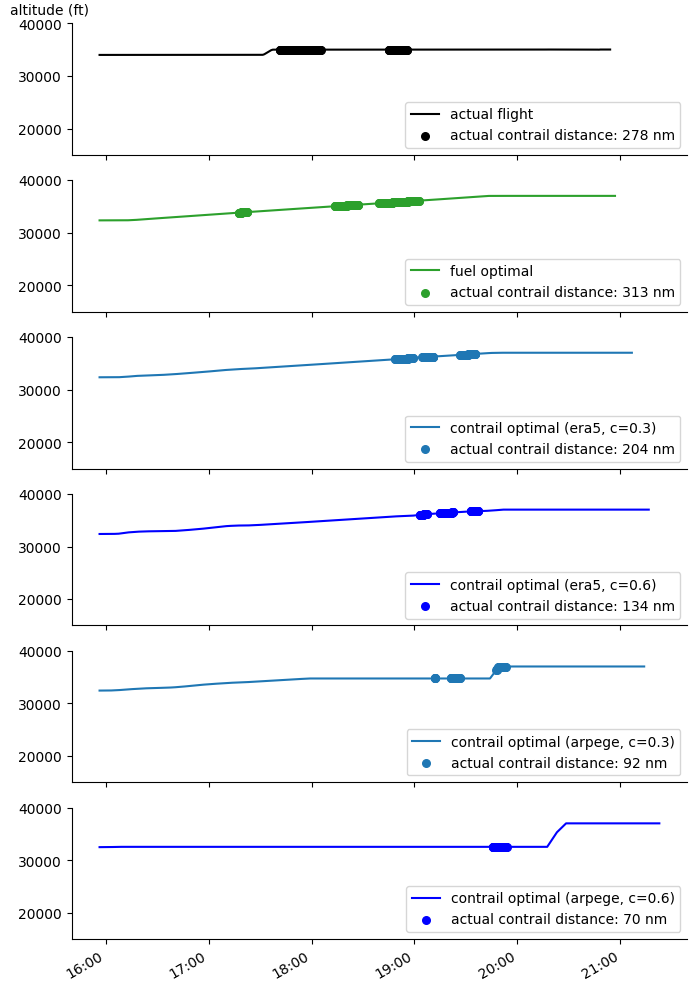

In [ ]:
flight = t_optimized[base_flight_id]
flight_opt_fuel = t_optimized[f"{base_flight_id}_fuel"]
flight_opt_era5_03 = t_optimized[f"{base_flight_id}_era5_03"]
flight_opt_era5_06 = t_optimized[f"{base_flight_id}_era5_06"]
flight_opt_arpege_03 = t_optimized[f"{base_flight_id}_arpege_03"]
flight_opt_arpege_06 = t_optimized[f"{base_flight_id}_arpege_06"]


flights = [
    flight,
    # flight.filter("aggressive"),
    flight_opt_fuel,
    flight_opt_era5_03,
    flight_opt_era5_06,
    flight_opt_arpege_03,
    flight_opt_arpege_06,
]

colors = ["k", "tab:green", "tab:blue", "blue", "tab:blue", "blue"]

labels = [
    "actual flight",
    "fuel optimal",
    "contrail optimal (era5, c=0.3)",
    "contrail optimal (era5, c=0.6)",
    "contrail optimal (arpege, c=0.3)",
    "contrail optimal (arpege, c=0.6)",
]


fig, axes = plt.subplots(6, 1, figsize=(7, 10), sharex=True, sharey=True)

for i, f in enumerate(flights):
    f = f.resample("10s")
    f = Flight(agg_contrail_conditions(arco_grid.interpolate(f.data)))

    contrail_distance = int(
        sum([fc.distance() for fc in f.query("persistent").split("5min")])
    )

    ax = axes[i]
    ax.plot(f.data.timestamp, f.data.altitude, label=labels[i], color=colors[i])
    ax.scatter(
        f.data.query("persistent").timestamp,
        f.data.query("persistent").altitude,
        color=colors[i],
        s=30,
        label=f"actual contrail distance: {contrail_distance} nm",
    )

    ax.legend(loc="lower right", ncol=1)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_label_coords(-0.1, 1.05)

    if i == 0:
        ax.set_ylabel("altitude (ft)", rotation=0, ha="left")
        ax.set_ylim(15_000, 40_000)

ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

fig.autofmt_xdate()
plt.tight_layout()


## Try another flight by yourself!